In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
stack = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')
print(stack.columns.tolist())

['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq', 'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites', 'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WelcomeChange', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro']


In [3]:
def get_description_and_unique (col_name, schema = schema):

    description = list(schema[schema['Column'] == col_name]['QuestionText'])[0]
    unique_values = stack[col_name].unique()
    return description, unique_values

In [4]:
get_description_and_unique('MainBranch')

('Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."',
 array(['I am a developer by profession', 'I code primarily as a hobby',
        'I used to be a developer by profession, but no longer am',
        'I am not primarily a developer, but I write code sometimes as part of my work',
        'I am a student who is learning to code', nan], dtype=object))

First list of columns
'Age', 'Age1stCode', 'YearsCode', 'ConvertedComp', 'Country', 'DevType', 'Employment', 'JobFactors', 
'JobSat','LanguageWorkedWith', 'NEWCollabToolsWorkedWith', 'NEWLearn', 'NEWPurchaseResearch',
'NEWOvertime', 'OpSys', 'OrgSize', 'UndergradMajor', 'WorkWeekHrs'

In [5]:
#Chosen variables
df = stack[['YearsCode', 'ConvertedComp', 'Employment', 'DevType', 'JobFactors', 'JobSat', 'LanguageWorkedWith',
        'NEWLearn', 'NEWOvertime', 'OpSys', 'OrgSize', 'UndergradMajor', 'WorkWeekHrs' ]]

In [6]:
df.head()

,YearsCode,ConvertedComp,Employment,DevType,JobFactors,JobSat,LanguageWorkedWith,NEWLearn,NEWOvertime,OpSys,OrgSize,UndergradMajor,WorkWeekHrs
0,36,NaN,"Independent contractor, freelancer, or self-em...","Developer, desktop or enterprise applications;...","Languages, frameworks, and other technologies ...",Slightly satisfied,C#;HTML/CSS;JavaScript,Once a year,Often: 1-2 days per week or more,Windows,2 to 9 employees,"Computer science, computer engineering, or sof...",50.0
1,7,NaN,Employed full-time,"Developer, full-stack;Developer, mobile",NaN,Very dissatisfied,JavaScript;Swift,Once a year,NaN,MacOS,"1,000 to 4,999 employees","Computer science, computer engineering, or sof...",NaN
2,4,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Once a decade,NaN,Linux-based,NaN,NaN,NaN
3,7,NaN,NaN,NaN,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,NaN,Once a year,Occasionally: 1-2 days per quarter but less th...,Linux-based,20 to 99 employees,"Computer science, computer engineering, or sof...",40.0
4,15,NaN,Employed full-time,NaN,NaN,NaN,HTML/CSS;Ruby;SQL,Once a year,NaN,Windows,NaN,"Computer science, computer engineering, or sof...",NaN


In [7]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearsCode           57684 non-null  object 
 1   ConvertedComp       34756 non-null  float64
 2   Employment          63854 non-null  object 
 3   DevType             49370 non-null  object 
 4   JobFactors          49349 non-null  object 
 5   JobSat              45194 non-null  object 
 6   LanguageWorkedWith  57378 non-null  object 
 7   NEWLearn            56156 non-null  object 
 8   NEWOvertime         43231 non-null  object 
 9   OpSys               56228 non-null  object 
 10  OrgSize             44334 non-null  object 
 11  UndergradMajor      50995 non-null  object 
 12  WorkWeekHrs         41151 non-null  float64
dtypes: float64(2), object(11)
memory usage: 6.4+ MB
None
       ConvertedComp   WorkWeekHrs
count   3.475600e+04  41151.000000
mean    1.037561e+05     40.

## Which were the most common programming languages in 2020?

In [8]:
def split_survey_string (dataset, col_name, sep_type):
    
    
    #Order values by count, rename columns and split strings
    temp = dataset[col_name].value_counts().reset_index()
    temp.rename(columns = {'index': 'method', col_name:'count'}, inplace = True)
    temp['method'] = temp['method'].str.split(sep_type)
    
    #Create a list with all separated values
    val_list = []
    for i in range(temp.shape[0]):
        for j in temp['method'][i]:
            val_list.append(j)
    
    #Convert list to series
    series = pd.Series(val_list)
    
    return series

In [9]:
language_split = split_survey_string (df, 'LanguageWorkedWith', ';')
ratio = (language_split.value_counts()/language_split.shape[0])

In [10]:
#Plot top 10 programming languages
def print_percentage_top(series, top_num, title):
    
    temp = series.head(top_num)
    
    plt.figure(figsize = [11.69, 8.27])
    base_color = sb.color_palette()[0]
    ax = sb.barplot(temp.index, temp.values, color = base_color)
    plt.title(title, fontsize = 18)


    #Remove plot frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #Draw y grid below the bars
    ax.set_axisbelow(True)
    ax.grid(axis='y')

    #Introducte percentages
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate( f'{height:.1%}', (x + width/2, y + height*1.02), ha='center')

    return ax

C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


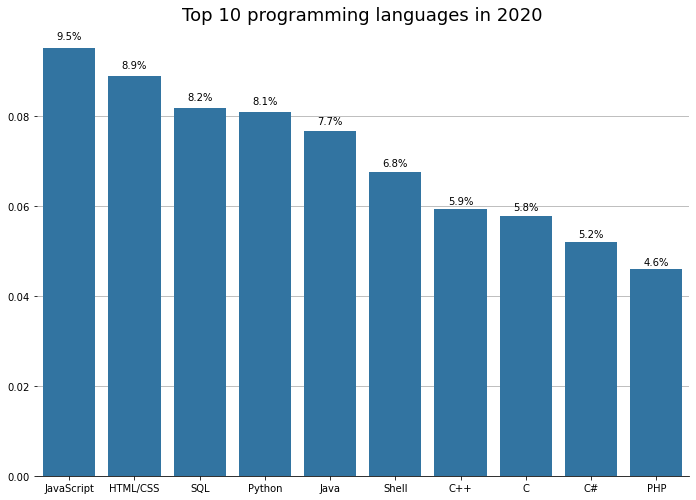

In [11]:
#Plot top 10 programming languages in 2020
ax = print_percentage_top(ratio, 10, 'Top 10 programming languages in 2020')

#Change the 5th label to fit properly in the plot
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[5] = 'Shell'
ax.set_xticklabels(labels)

plt.show()

C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


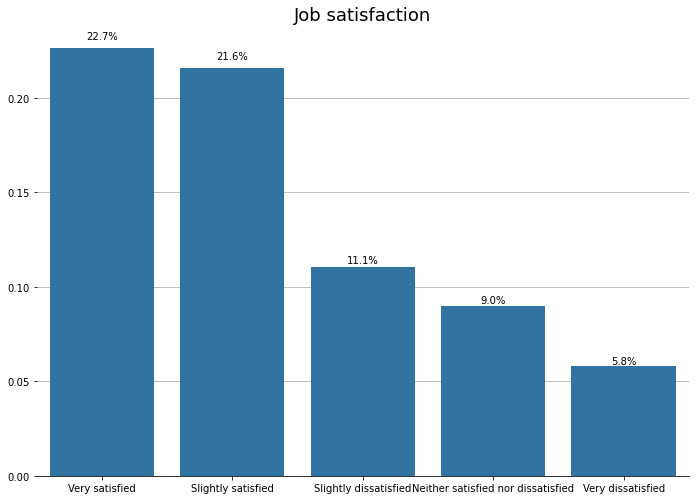

In [12]:
ratio1 = (df.JobSat.value_counts()/df.JobSat.shape[0])
ax1 = print_percentage_top(ratio1, 6, title = 'Job satisfaction')
plt.show()

C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


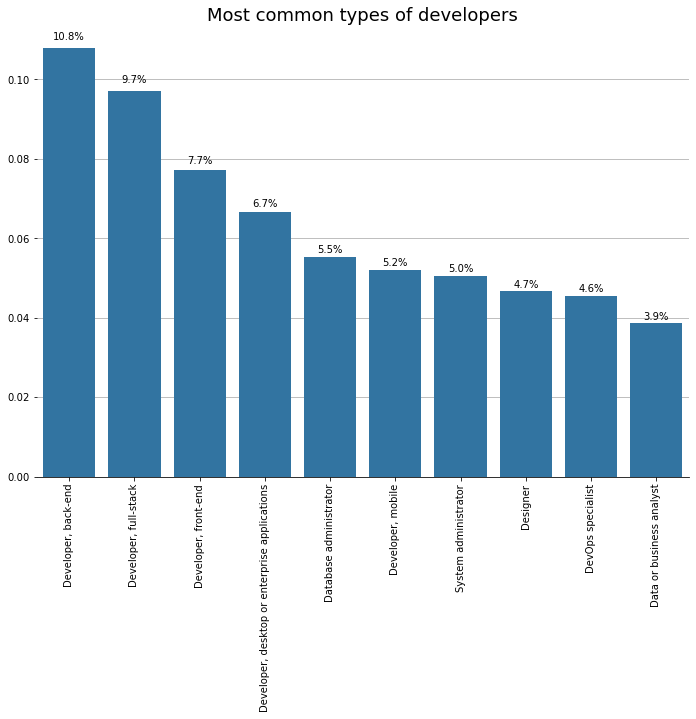

In [13]:
dev_split = split_survey_string (df, 'DevType', ';')
ratio2 = (dev_split.value_counts()/dev_split.shape[0])

ax = print_percentage_top(ratio2, 10, 'Most common types of developers')
plt.xticks(rotation='vertical')
plt.show()

## Which variables influence more the salary?

### Understand correlations

In [14]:
df.groupby(['OrgSize']).mean()['ConvertedComp'].sort_values()

OrgSize
2 to 9 employees                                       70442.627061
10 to 19 employees                                     72679.088889
Just me - I am a freelancer, sole proprietor, etc.     81785.383029
20 to 99 employees                                     94023.045251
500 to 999 employees                                  101318.937500
100 to 499 employees                                  104225.637022
5,000 to 9,999 employees                              124124.810638
1,000 to 4,999 employees                              124722.418370
10,000 or more employees                              144626.001659
Name: ConvertedComp, dtype: float64

In [15]:
df.groupby(['OpSys']).mean()['ConvertedComp'].sort_values()

OpSys
Linux-based     94115.891307
Windows         95247.657566
MacOS          124645.584771
BSD            151049.904762
Name: ConvertedComp, dtype: float64

In [16]:
df.groupby(['NEWLearn']).mean()['ConvertedComp'].sort_values()

NEWLearn
Every few months         90159.160298
Once a decade           107657.616176
Once a year             108207.117812
Once every few years    114359.123566
Name: ConvertedComp, dtype: float64

¿Como es posible que los que aprendan mas amenudo tengan menos salario?

In [17]:
df.groupby(['NEWOvertime']).mean()['ConvertedComp'].sort_values()

NEWOvertime
Never                                                        99101.325409
Often: 1-2 days per week or more                             99388.780387
Sometimes: 1-2 days per month but less than weekly          100568.936536
Rarely: 1-2 days per year or less                           106837.885517
Occasionally: 1-2 days per quarter but less than monthly    112275.550806
Name: ConvertedComp, dtype: float64

In [18]:
df.groupby(['UndergradMajor']).mean()['ConvertedComp'].sort_values()


UndergradMajor
A health science (such as nursing, pharmacy, radiology, etc.)                      70738.669291
Web development or web design                                                      79894.124477
Another engineering discipline (such as civil, electrical, mechanical, etc.)       92776.573866
Information systems, information technology, or system administration              93816.513949
Computer science, computer engineering, or software engineering                   102308.640904
A business discipline (such as accounting, finance, marketing, etc.)              109906.890909
A natural science (such as biology, chemistry, physics, etc.)                     113949.783838
Mathematics or statistics                                                         130102.592994
A social science (such as anthropology, psychology, political science, etc.)      130689.137097
I never declared a major                                                          134906.594828
A humanities discipline (

In [19]:
df.loc[df.YearsCode == 'Less than 1 year', 'YearsCode'] = 0
df.loc[df.YearsCode == 'More than 50 years', 'YearsCode'] = 51
df['YearsCode'] = df['YearsCode'].astype(float)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearsCode           57684 non-null  float64
 1   ConvertedComp       34756 non-null  float64
 2   Employment          63854 non-null  object 
 3   DevType             49370 non-null  object 
 4   JobFactors          49349 non-null  object 
 5   JobSat              45194 non-null  object 
 6   LanguageWorkedWith  57378 non-null  object 
 7   NEWLearn            56156 non-null  object 
 8   NEWOvertime         43231 non-null  object 
 9   OpSys               56228 non-null  object 
 10  OrgSize             44334 non-null  object 
 11  UndergradMajor      50995 non-null  object 
 12  WorkWeekHrs         41151 non-null  float64
dtypes: float64(3), object(10)
memory usage: 6.4+ MB
None


C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-19-62926fc1ec5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YearsCode'] = df['YearsCode'].astype(float)


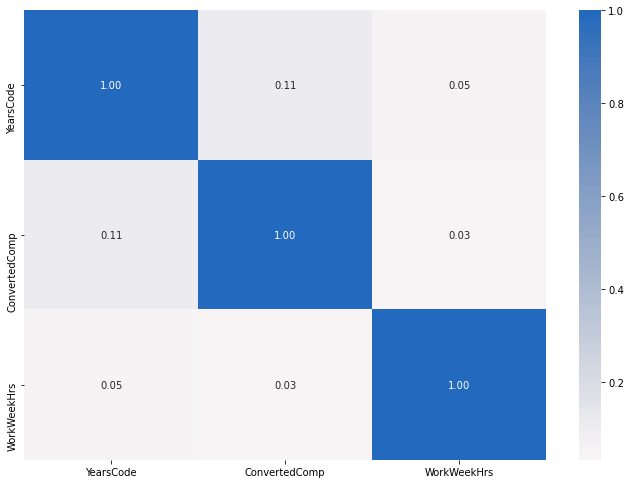

In [20]:
plt.figure(figsize = [11.69, 8.27])
sb.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.show()

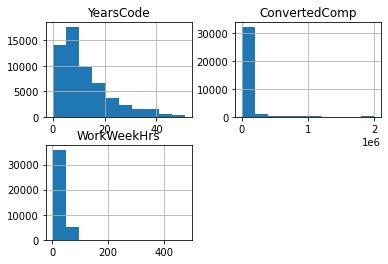

In [21]:
df.hist();

### Work with Nan values

In [22]:
def miss_data(df):
    missing_data = pd.DataFrame(columns = ['column_name','missing_data', 'missing_in_percentage'])
    columns = df.columns
    for col in columns:
        missing_sum = df[col].isnull().sum()
        missing_percentage = (df[col].isnull().mean())*100     
        missing_data.loc[len(missing_data)] = [col, missing_sum, missing_percentage]
    print(missing_data) 

In [23]:
miss_data(df)

           column_name missing_data  missing_in_percentage
0            YearsCode         6777              10.513334
1        ConvertedComp        29705              46.082127
2           Employment          607               0.941655
3              DevType        15091              23.411055
4           JobFactors        15112              23.443633
5               JobSat        19267              29.889390
6   LanguageWorkedWith         7083              10.988039
7             NEWLearn         8305              12.883759
8          NEWOvertime        21230              32.934643
9                OpSys         8233              12.772064
10             OrgSize        20127              31.223531
11      UndergradMajor        13466              20.890151
12         WorkWeekHrs        23310              36.161400


In [26]:
fill_mean = lambda col: col.fillna(col.mean())

C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [27]:
fill_mode = lambda col: col.fillna(col.mode()[0])

### Dummy variables

scale_mapper = {'Very dissatisfied':1, 'Slightly dissatisfied':2, 'Neither satisfied nor dissatisfied':3,
               'Slightly satisfied':4, 'Very satisfied':5}
df['JobSat'] = df['JobSat'].replace(scale_mapper)

In [29]:
def dummy_array(df, col_list):
    '''
    The columns in col_list must have each observation as an array with the elements separated by ';' 
    Creates dummy columns for each variable in col_list
    Removes the original columns
    Chooses if create a variable for the Nan values in dummy_na
    '''

    #Create a dummy variable for each language or devtype
    for item in col_list:
        split = df[item].str.strip('[]').str.split('\s*;')
        dummy = (split.explode().str.get_dummies().sum(level=0).add_prefix(item + '_'))
        df = df.drop([item], 1).join([dummy])
    
    return df

In [30]:
#Dataframe with dummy variables related to the columns with categorical values with array structure
list_like_var = ['DevType', 'LanguageWorkedWith', 'JobFactors']

,YearsCode,ConvertedComp,Employment,JobSat,NEWLearn,NEWOvertime,OpSys,OrgSize,UndergradMajor,WorkWeekHrs,...,JobFactors_Family friendliness,JobFactors_Financial performance or funding status of the company or organization,JobFactors_Flex time or a flexible schedule,JobFactors_How widely used or impactful my work output would be,JobFactors_Industry that I’d be working in,"JobFactors_Languages, frameworks, and other technologies I’d be working with",JobFactors_Office environment or company culture,JobFactors_Opportunities for professional development,JobFactors_Remote work options,JobFactors_Specific department or team I’d be working on
7,17.0,116000.0,Employed full-time,Slightly dissatisfied,Once a year,Occasionally: 1-2 days per quarter but less th...,Linux-based,20 to 99 employees,"Computer science, computer engineering, or sof...",39.0,...,1,0,0,0,0,0,0,1,1,0
9,8.0,32315.0,Employed full-time,Very satisfied,Every few months,Often: 1-2 days per week or more,Windows,2 to 9 employees,Mathematics or statistics,36.0,...,0,0,1,1,0,0,0,1,0,0
10,10.0,40070.0,Employed full-time,Slightly dissatisfied,Every few months,Rarely: 1-2 days per year or less,Windows,"10,000 or more employees","Computer science, computer engineering, or sof...",40.0,...,0,0,1,0,0,1,0,0,1,0
11,7.0,14268.0,Employed full-time,Very dissatisfied,Once every few years,Rarely: 1-2 days per year or less,Windows,2 to 9 employees,Mathematics or statistics,40.0,...,1,0,0,0,0,0,1,0,1,0
12,35.0,38916.0,Employed full-time,Very satisfied,Once every few years,Rarely: 1-2 days per year or less,MacOS,2 to 9 employees,"Computer science, computer engineering, or sof...",36.0,...,0,1,0,0,1,0,1,0,0,0


In [31]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

##  Clean function

In [33]:
def clean_data_regression(df, response_var, array_cat_list, dummy_na):
    
    #Drop the rows with missing values in the response_var column
    df = df.dropna(subset = [response_var], axis=0)
    
    #Dummy array-variables
    df = df.dropna(subset = array_cat_list, axis = 0)
    df = dummy_array(df, array_cat_list)    
    y = df[response_var]
    
    #Drop the response_var column from the dataframe
    df = df.drop([response_var], axis = 1)
    
    #Fill numeric columns with mean and categorical columns with mode
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col] = df[[col]].apply(fill_mean)
    
    #Categorical values list
    cat_vars = (df_dummy_array.select_dtypes(include=['object'])).columns
    #Decides if it fills the nan categorical values with the mode
    if dummy_na == True:
        pass
    else:
        for col in cat_vars:
            df[col] = df[col].apply(fill_mode)
            
    #Dummy normal categorical values
    df = create_dummy_df(df, cat_vars, dummy_na = dummy_na) 
    df.info()
    X = df
    miss_data(X)
    return X, y

In [34]:
X, y = clean_data_regression(df, 'ConvertedComp', list_like_var, True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32206 entries, 7 to 64111
Columns: 103 entries, YearsCode to UndergradMajor_nan
dtypes: float64(2), int64(59), uint8(42)
memory usage: 17.5 MB
                                           column_name missing_data  \
0                                            YearsCode            0   
1                                          WorkWeekHrs            0   
2                          DevType_Academic researcher            0   
3                     DevType_Data or business analyst            0   
4    DevType_Data scientist or machine learning spe...            0   
..                                                 ...          ...   
98             UndergradMajor_I never declared a major            0   
99   UndergradMajor_Information systems, informatio...            0   
100           UndergradMajor_Mathematics or statistics            0   
101       UndergradMajor_Web development or web design            0   
102                       

### Linear regression

In [44]:
X['intercept'] = 1

lm = sm.OLS(y, X, axis = 1)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConvertedComp   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     17.02
Date:                Tue, 02 Mar 2021   Prob (F-statistic):          6.49e-271
Time:                        22:30:50   Log-Likelihood:            -4.7713e+05
No. Observations:               34756   AIC:                         9.545e+05
Df Residuals:                   34659   BIC:                         9.553e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
YearsCode                                                                                      1945.7160    142.258     13.677      0.000    1666.886    2224.546
WorkWeekHrs                                                                                     270.6704     68.947      3.926      0.000     135.531     405.809
DevType_Academic researcher                                                                   -3.061e+04   5663.813     -5.405      0.000   -4.17e+04   -1.95e+04
DevType_Data or business analyst                                                               3357.8650   5062.503      0.663      0.507   -6564.804    1.33e+04
DevType_Data scientist or machine learning specialist                                           1.65e+04   5259.544      3.137      0.002    6192.752    2.68e+04
DevType_Database administrator                                                                 5432.4669   4385.506      1.239      0.215   -3163.266     1.4e+04
DevType_Designer                                                                               9656.3927   4408.425      2.190      0.028    1015.736    1.83e+04
DevType_DevOps specialist                                                                     -3591.9093   3915.850     -0.917      0.359   -1.13e+04    4083.284
DevType_Developer, QA or test                                                                 -5647.3962   4577.317     -1.234      0.217   -1.46e+04    3324.294
DevType_Developer, back-end                                                                   -3554.4203   2718.653     -1.307      0.191   -8883.068    1774.227
DevType_Developer, desktop or enterprise applications                                         -3614.4287   3158.052     -1.145      0.252   -9804.312    2575.455
DevType_Developer, embedded applications or devices                                            1.184e+04   4535.942      2.611      0.009    2950.551    2.07e+04
DevType_Developer, front-end                                                                   2577.5630   3028.513      0.851      0.395   -3358.421    8513.547
DevType_Developer, full-stack                                                                  8652.1218   2827.522      3.060      0.002    3110.087    1.42e+04
DevType_Developer, game or graphics                                                            3685.4963   5710.663      0.645      0.519   -7507.589    1.49e+04
DevType_Developer, mobile                                                                     -1.325e+04   3648.050     -3.631      0.000   -2.04e+04   -6096.105
DevTy

In [45]:
# Consider only numerical variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Four steps:

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit - why does this break?
lm_model.fit(X_train, y_train) 

#Predict
#Score

LinearRegression(normalize=True)

In [46]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

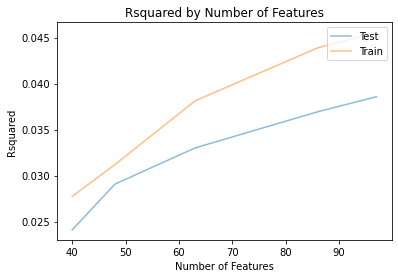

In [47]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [49]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(15)

,est_int,coefs,abs_coefs
74,OpSys_Linux-based,-128868.932082,128868.932082
76,OpSys_Windows,-120830.250872,120830.250872
75,OpSys_MacOS,-101009.821923,101009.821923
36,LanguageWorkedWith_Julia,54800.802444,54800.802444
80,OrgSize_2 to 9 employees,-51131.139854,51131.139854
84,"OrgSize_Just me - I am a freelancer, sole prop...",-44629.413950,44629.413950
77,OrgSize_10 to 19 employees,-43032.912152,43032.912152
61,Employment_Employed part-time,-37657.138017,37657.138017
91,UndergradMajor_Fine arts or performing arts (s...,35766.309291,35766.309291
20,DevType_Marketing or sales professional,35750.179778,35750.179778


#Useful functions of the course
most_missing_cols = set(df.columns[df.isnull().mean() > 0.75]) #Provide a set of columns with more than 75% of the values missing
no_nulls = set(df.columns[df.isnull().mean()==0]) #Provide a set of columns with 0 missing values.
(ed_vals/df.shape[0]).plot(kind="bar"); # The below should be a bar chart of the proportion of individuals in your ed_vals

#Mean salaries grouped by sex and education
pd.DataFrame(df.query("Professional == 'Professional developer' and (Gender == 'Male' or Gender == 'Female')").groupby(['Gender', 'FormalEducation']).mean()['Salary'])

#Remove outliers
from scipy import stats
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]